In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
from tqdm import tqdm
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import scipy.stats as stats
import statsmodels.stats.multicomp as mc
from scipy.stats import normaltest
from scipy.stats import shapiro
import scikit_posthocs as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols
import math
import os

# CMA aging Atlas: Lung
Data downloaded from [Tabula muris senis](https://cellxgene.cziscience.com/collections/0b9d8a04-bb9d-44da-aa27-705bb65b54eb) project. Lung data, Smart-seq2 assay in .h5ad format was used for further analysis.

In [2]:
# Creating folder for outputs
os.makedirs('../Khwaja_et_al_outputs/Lung')

## Importing and preprocessing data

In [2]:
# Import h5ad file in scanpy. 
adata = sc.read_h5ad('../Exp. 2_Tabula muris/Files/TM_lung_smartseq.h5ad')

# Normalize as CPM (counts per million)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e6)

# Transforming CPM into log form
sc.pp.log1p(adata)

## CMA score calculation

In [3]:
# Load matrix file with weight and direction 
model_matrix = pd.read_excel('../Exp. 2_Tabula muris/activation_model.xlsx')

# Removing EEF1A1 and RAC1 genes because they don't appear in the adata
model_matrix = model_matrix.drop([6, 8], axis=0).reset_index()

# Finding CMA network genes in the dataset
cma_network = adata[:, model_matrix["Ensembl_ms"]]

# Calculating the Zs scores
cma_data_zs = cma_network.copy().X.todense().T

for i in tqdm(np.arange(cma_data_zs.shape[0])):
    
    µ = np.mean(cma_data_zs[i, :])
    sd = np.std(cma_data_zs[i, :])
    
    cma_data_zs[i, :] = (cma_data_zs[i, :] - µ)/sd
    
# Generating a copy of adata.obs to work with
barcode = adata.obs.copy()

# New column in barcode (aka adata.obs) with the CMA scores for each cell detected
for i,j in enumerate(barcode.index):
        
    cell_matrix = model_matrix.copy()

    for g in cell_matrix.index:

        cell_matrix.loc[g, 'gene_count'] = cma_data_zs[g, i]

    cell_matrix['gene_score'] = cell_matrix['gene_count'] * cell_matrix['Direction'] * cell_matrix['Weight']
    score = cell_matrix['gene_score'].sum()/np.sum(cell_matrix['Weight'])

    barcode.loc[j, 'score'] = score   
    

100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 3040.59it/s]


In [5]:
barcode.head()

,FACS.selection,age,cell,free_annotation,method,mouse.id,subtissue,n_genes,n_counts,louvain,...,organism_ontology_term_id,cell_type,assay,disease,organism,sex,tissue,ethnicity,development_stage,score
index,,,,,,,,,,,,,,,,,,,,,
A10_B000229_B009899_S10.mm10-plus-4-0,Multiple,18m,A10_B000229,Capillary,facs,18_53_M,Endomucin,1464,2954.479248,0,...,NCBITaxon:10090,bronchial smooth muscle cell,Smart-seq2,normal,Mus musculus,male,lung,na,18 month-old stage,0.033605
A10_B000248_B009895_S10.mm10-plus-4-0,Multiple,18m,A10_B000248,Alveolar Fibroblast,facs,18_53_M,EPCAM,1445,2868.977783,12,...,NCBITaxon:10090,fibroblast of lung,Smart-seq2,normal,Mus musculus,male,lung,na,18 month-old stage,0.028476
A10_B000265_B009901_S10.mm10-plus-4-0,Multiple,18m,A10_B000265,Capillary Aerocyte,facs,18_47_F,ENDOMUCIN,3839,4576.779297,1,...,NCBITaxon:10090,bronchial smooth muscle cell,Smart-seq2,normal,Mus musculus,female,lung,na,18 month-old stage,0.448926
A10_B000266_B009900_S10.mm10-plus-4-0,Multiple,18m,A10_B000266,Capillary,facs,18_46_F,ENDOMUCIN,2940,5336.978516,1,...,NCBITaxon:10090,bronchial smooth muscle cell,Smart-seq2,normal,Mus musculus,female,lung,na,18 month-old stage,0.216423
A10_B002258_B009940_S10.mm10-plus-4-0,Multiple,18m,A10_B002258,Capillary,facs,18_45_M,ENDOMUCIN,3122,4465.913086,2,...,NCBITaxon:10090,bronchial smooth muscle cell,Smart-seq2,normal,Mus musculus,male,lung,na,18 month-old stage,0.349334


## CMA net score/cell type (fold over whole tissue)

In [10]:
# Checking n of mice 
print(list(barcode['mouse.id'].unique()))

['18_53_M', '18_47_F', '18_46_F', '18_45_M', '24_60_M', '24_59_M', '24_58_M', '24_61_M', '3_39_F', '3_38_F', '3_8_M', '3_9_M', '3_11_M', '3_10_M']


**Mice n for Liver**
    - Young females: 2
    - Young males: 4
    - Old females: 2
    - Old males: 6

In [4]:
# Generating new ages
for j in barcode.index:    
    if barcode.loc[j, 'age'] == '3m':        
        barcode.loc[j, 'new_age'] = '3m'

    elif barcode.loc[j, 'age'] == '18m':                
        barcode.loc[j, 'new_age'] = '18-24m'

    elif barcode.loc[j, 'age'] == '24m': 
        barcode.loc[j, 'new_age'] = '18-24m'
barcode.head()

,FACS.selection,age,cell,free_annotation,method,mouse.id,subtissue,n_genes,n_counts,louvain,...,cell_type,assay,disease,organism,sex,tissue,ethnicity,development_stage,score,new_age
index,,,,,,,,,,,,,,,,,,,,,
A10_B000229_B009899_S10.mm10-plus-4-0,Multiple,18m,A10_B000229,Capillary,facs,18_53_M,Endomucin,1464,2954.479248,0,...,bronchial smooth muscle cell,Smart-seq2,normal,Mus musculus,male,lung,na,18 month-old stage,0.033605,18-24m
A10_B000248_B009895_S10.mm10-plus-4-0,Multiple,18m,A10_B000248,Alveolar Fibroblast,facs,18_53_M,EPCAM,1445,2868.977783,12,...,fibroblast of lung,Smart-seq2,normal,Mus musculus,male,lung,na,18 month-old stage,0.028476,18-24m
A10_B000265_B009901_S10.mm10-plus-4-0,Multiple,18m,A10_B000265,Capillary Aerocyte,facs,18_47_F,ENDOMUCIN,3839,4576.779297,1,...,bronchial smooth muscle cell,Smart-seq2,normal,Mus musculus,female,lung,na,18 month-old stage,0.448926,18-24m
A10_B000266_B009900_S10.mm10-plus-4-0,Multiple,18m,A10_B000266,Capillary,facs,18_46_F,ENDOMUCIN,2940,5336.978516,1,...,bronchial smooth muscle cell,Smart-seq2,normal,Mus musculus,female,lung,na,18 month-old stage,0.216423,18-24m
A10_B002258_B009940_S10.mm10-plus-4-0,Multiple,18m,A10_B002258,Capillary,facs,18_45_M,ENDOMUCIN,3122,4465.913086,2,...,bronchial smooth muscle cell,Smart-seq2,normal,Mus musculus,male,lung,na,18 month-old stage,0.349334,18-24m


In [5]:
# Calculation of net score to 3m using whole tissue CMA score mean
µ = np.mean(barcode[barcode['new_age'] == '3m']['score'])

for i in barcode.index:
    barcode.loc[i, 'net_score'] = barcode.loc[i, 'score'] - µ 

barcode.head()

,FACS.selection,age,cell,free_annotation,method,mouse.id,subtissue,n_genes,n_counts,louvain,...,assay,disease,organism,sex,tissue,ethnicity,development_stage,score,new_age,net_score
index,,,,,,,,,,,,,,,,,,,,,
A10_B000229_B009899_S10.mm10-plus-4-0,Multiple,18m,A10_B000229,Capillary,facs,18_53_M,Endomucin,1464,2954.479248,0,...,Smart-seq2,normal,Mus musculus,male,lung,na,18 month-old stage,0.033605,18-24m,0.019078
A10_B000248_B009895_S10.mm10-plus-4-0,Multiple,18m,A10_B000248,Alveolar Fibroblast,facs,18_53_M,EPCAM,1445,2868.977783,12,...,Smart-seq2,normal,Mus musculus,male,lung,na,18 month-old stage,0.028476,18-24m,0.013949
A10_B000265_B009901_S10.mm10-plus-4-0,Multiple,18m,A10_B000265,Capillary Aerocyte,facs,18_47_F,ENDOMUCIN,3839,4576.779297,1,...,Smart-seq2,normal,Mus musculus,female,lung,na,18 month-old stage,0.448926,18-24m,0.434399
A10_B000266_B009900_S10.mm10-plus-4-0,Multiple,18m,A10_B000266,Capillary,facs,18_46_F,ENDOMUCIN,2940,5336.978516,1,...,Smart-seq2,normal,Mus musculus,female,lung,na,18 month-old stage,0.216423,18-24m,0.201896
A10_B002258_B009940_S10.mm10-plus-4-0,Multiple,18m,A10_B002258,Capillary,facs,18_45_M,ENDOMUCIN,3122,4465.913086,2,...,Smart-seq2,normal,Mus musculus,male,lung,na,18 month-old stage,0.349334,18-24m,0.334807


In [8]:
print(list(barcode.cell_type.unique()))

['bronchial smooth muscle cell', 'fibroblast of lung', 'adventitial cell', 'myeloid dendritic cell', 'pericyte cell', 'vein endothelial cell', 'B cell', 'smooth muscle cell of the pulmonary artery', 'CD8-positive, alpha-beta T cell', 'neutrophil', 'classical monocyte', 'CD4-positive, alpha-beta T cell', 'T cell', 'plasma cell', 'plasmacytoid dendritic cell', 'regulatory T cell', 'club cell', 'respiratory basal cell', 'dendritic cell', 'endothelial cell of lymphatic vessel', 'natural killer cell', 'type II pneumocyte', 'non-classical monocyte', 'ciliated columnar cell of tracheobronchial tree', 'pulmonary interstitial fibroblast', 'intermediate monocyte', 'lymphocyte', 'leukocyte', 'lung neuroendocrine cell', 'lung macrophage', 'mature NK T cell', 'type I pneumocyte']


In [7]:
cells = ['type I pneumocyte', 'type II pneumocyte', 'fibroblast of lung', 'adventitial cell', 
         'pulmonary interstitial fibroblast', 'vein endothelial cell', 'endothelial cell of lymphatic vessel'] 

In [8]:
# Generating new cell types combining some of them
for j in barcode.index:    
    if barcode.loc[j, 'cell_type'] == cells[0]:        
        barcode.loc[j, 'new_cell'] = 'pneumocyte'

    elif barcode.loc[j, 'cell_type'] == cells[1]:                
        barcode.loc[j, 'new_cell'] = 'pneumocyte'

    elif barcode.loc[j, 'cell_type'] == cells[2]:                
        barcode.loc[j, 'new_cell'] = 'fibroblast'
    
    elif barcode.loc[j, 'cell_type'] == cells[3]:                
        barcode.loc[j, 'new_cell'] = 'fibroblast'
    
    elif barcode.loc[j, 'cell_type'] == cells[4]:                
        barcode.loc[j, 'new_cell'] = 'fibroblast'
    
    elif barcode.loc[j, 'cell_type'] == cells[5]:                
        barcode.loc[j, 'new_cell'] = 'endothelial'
    
    elif barcode.loc[j, 'cell_type'] == cells[6]:                
        barcode.loc[j, 'new_cell'] = 'endothelial'
    
    else:
        barcode.loc[j, 'new_cell'] = barcode.loc[j, 'cell_type']
        
barcode.head()

,FACS.selection,age,cell,free_annotation,method,mouse.id,subtissue,n_genes,n_counts,louvain,...,disease,organism,sex,tissue,ethnicity,development_stage,score,new_age,net_score,new_cell
index,,,,,,,,,,,,,,,,,,,,,
A10_B000229_B009899_S10.mm10-plus-4-0,Multiple,18m,A10_B000229,Capillary,facs,18_53_M,Endomucin,1464,2954.479248,0,...,normal,Mus musculus,male,lung,na,18 month-old stage,0.033605,18-24m,0.019078,bronchial smooth muscle cell
A10_B000248_B009895_S10.mm10-plus-4-0,Multiple,18m,A10_B000248,Alveolar Fibroblast,facs,18_53_M,EPCAM,1445,2868.977783,12,...,normal,Mus musculus,male,lung,na,18 month-old stage,0.028476,18-24m,0.013949,fibroblast
A10_B000265_B009901_S10.mm10-plus-4-0,Multiple,18m,A10_B000265,Capillary Aerocyte,facs,18_47_F,ENDOMUCIN,3839,4576.779297,1,...,normal,Mus musculus,female,lung,na,18 month-old stage,0.448926,18-24m,0.434399,bronchial smooth muscle cell
A10_B000266_B009900_S10.mm10-plus-4-0,Multiple,18m,A10_B000266,Capillary,facs,18_46_F,ENDOMUCIN,2940,5336.978516,1,...,normal,Mus musculus,female,lung,na,18 month-old stage,0.216423,18-24m,0.201896,bronchial smooth muscle cell
A10_B002258_B009940_S10.mm10-plus-4-0,Multiple,18m,A10_B002258,Capillary,facs,18_45_M,ENDOMUCIN,3122,4465.913086,2,...,normal,Mus musculus,male,lung,na,18 month-old stage,0.349334,18-24m,0.334807,bronchial smooth muscle cell


In [8]:
cells = ['pneumocyte', 'fibroblast', 'endothelial']

### Cell types stats

In [15]:
# Function for testing normality using D'Agostino-Pearson of different cell types and ages
def normalidad (df, tipo, años):
    long = []
    cell = []
    age = []
    estadistica=[]
    pval=[]
    result=[]   
    
    for x in tipo:
        for y in años:
            mydata = df[(df['new_cell']== x) & (df['new_age']== y)]
            n = len(mydata.index)
            data = list(mydata.net_score)            
            stat, p = normaltest(data)
            long.append(n)
            cell.append(x)
            age.append(y)
            estadistica.append(stat)
            pval.append(p)
            if p > 0.05:
                result.append("Normal")
            else:
                result.append("Not normal")    
    df_norm = pd.DataFrame({"Cell": cell, "Age": age, "n": long, "Stat":estadistica, "p value": pval, "Result":result})
    return(df_norm)

In [16]:
normalidad(barcode, tipo=cells, años=['3m', '18-24m'])

,Cell,Age,n,Stat,p value,Result
0,pneumocyte,3m,100,3.069362,0.215524,Normal
1,pneumocyte,18-24m,71,1.512551,0.469411,Normal
2,fibroblast,3m,308,23.532559,0.000008,Not normal
3,fibroblast,18-24m,514,4.247425,0.119587,Normal
4,endothelial,3m,90,2.427830,0.297032,Normal
5,endothelial,18-24m,161,2.550725,0.279330,Normal


In [18]:
# T test for normal populations
for i in ['pneumocyte', 'endothelial']:
    # Levene
    group3 = list(barcode[barcode.new_cell==i][barcode.new_age=='3m']['net_score'])
    group18_24 = list(barcode[barcode.new_cell==i][barcode.new_age=='18-24m']['net_score'])
    print('{} stats'.format(i.title()))
    print("Length 3m: " + str(len(group3)))
    print("Length 18-24m: " + str(len(group18_24)))
    stat, p = stats.levene(group3, group18_24)
    print("Levene's test pval = " + str(p))

    #t test
    if i == 'pneumocyte':
        stat2, p2 = stats.ttest_ind(group3, group18_24, equal_var=False)
        print("T test pval = " + str(p2))
        print('\n')
    
    else:
        stat2, p2 = stats.ttest_ind(group3, group18_24, equal_var=True)
        print("T test pval = " + str(p2))
        print('\n')

Pneumocyte stats
Length 3m: 100
Length 18-24m: 71
Levene's test pval = 0.00011239783477203141
T test pval = 0.00030236912209054707


Endothelial stats
Length 3m: 90
Length 18-24m: 161
Levene's test pval = 0.31162351030569274
T test pval = 0.07401625446370999




C:\Users\Adrian\AppData\Local\Temp\ipykernel_8700\1568574157.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group3 = list(barcode[barcode.new_cell==i][barcode.new_age=='3m']['net_score'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_8700\1568574157.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group18_24 = list(barcode[barcode.new_cell==i][barcode.new_age=='18-24m']['net_score'])


In [20]:
# Calculating MWU test (for not normal distributions) for the cells of interest
for i in ['fibroblast']:
    group3 = list(barcode[barcode.new_cell==i][barcode.new_age=='3m']['net_score'])
    group18_24 = list(barcode[barcode.new_cell==i][barcode.new_age=='18-24m']['net_score'])
    print('{} statistics'.format(i.title()))
    stat, p = stats.mannwhitneyu(group3, group18_24)
    print("MWU test pval = " + str(p))
    print('\n')

Fibroblast statistics
MWU test pval = 0.170948727868514




C:\Users\Adrian\AppData\Local\Temp\ipykernel_8700\2360819185.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group3 = list(barcode[barcode.new_cell==i][barcode.new_age=='3m']['net_score'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_8700\2360819185.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group18_24 = list(barcode[barcode.new_cell==i][barcode.new_age=='18-24m']['net_score'])


### Net score graph

C:\Users\Adrian\AppData\Local\Temp\ipykernel_8700\359238654.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y1= np.mean(barcode[barcode.new_cell =='pneumocyte'][barcode.new_age=='18-24m']['net_score']) - (0.011)


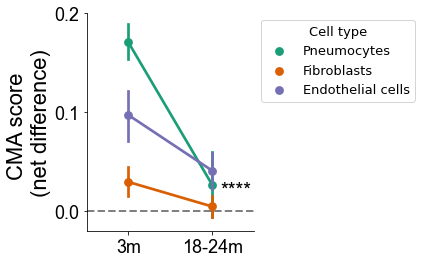

In [29]:
# CMA net score by cell type
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.pointplot(x='new_age', y='net_score', data=barcode, hue='new_cell', order=["3m", "18-24m"], 
              hue_order=["pneumocyte", 'fibroblast', 'endothelial'], palette="Dark2", ci=68)
plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticklabels(["3m", "18-24m"], fontdict={'family':'Arial', 'size': 18})
plt.xlabel('')
plt.ylim(-0.02, 0.20) 
ax.set_yticks([0.00, 0.10, 0.20])
ax.set_yticklabels([0.00, 0.10, 0.20], fontdict={'family':'Arial', 'size': 18})

# Legend
celulas = ["Pneumocytes", 'Fibroblasts', 'Endothelial cells']
h, l = ax.get_legend_handles_labels()
ax.legend(h, celulas, bbox_to_anchor=(2, 1), title="Cell type", title_fontsize = "13", fontsize=13) 

# Stats
x1= 1.1   
y1= np.mean(barcode[barcode.new_cell =='pneumocyte'][barcode.new_age=='18-24m']['net_score']) - (0.011)
plt.text(x1, y1, "****", fontsize=20, **hfont)

plt.savefig('../Khwaja_et_al_outputs/Lung/Lung_nscorrect.png',bbox_inches='tight', dpi=300)

plt.show()

### Raw data

In [30]:
# Extracting raw values for pointplot graphic
long = []
celula = []
age = []
mean=[]
sem=[]

for x in cells:
    for y in ['3m', '18-24m']:
        n = len(barcode[barcode['new_cell']== x][barcode['new_age']== y].index)
        m = np.mean(barcode[barcode['new_cell']== x][barcode['new_age']== y]['net_score'])
        s = stats.sem(np.array(barcode[barcode['new_cell']== x][barcode['new_age']== y]['net_score']))
        
        long.append(n)
        celula.append(x)
        age.append(y)
        mean.append(m)
        sem.append(s)
        
df_raw = pd.DataFrame({"Cell_type": celula, "Age": age, "n": long, "Mean":mean, "SEM": sem})
df_raw

C:\Users\Adrian\AppData\Local\Temp\ipykernel_8700\1532967860.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n = len(barcode[barcode['new_cell']== x][barcode['new_age']== y].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_8700\1532967860.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = np.mean(barcode[barcode['new_cell']== x][barcode['new_age']== y]['net_score'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_8700\1532967860.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  s = stats.sem(np.array(barcode[barcode['new_cell']== x][barcode['new_age']== y]['net_score']))


,Cell_type,Age,n,Mean,SEM
0,pneumocyte,3m,100,0.170737,0.017970
1,pneumocyte,18-24m,71,0.026764,0.034114
2,fibroblast,3m,308,0.029433,0.014320
3,fibroblast,18-24m,514,0.004613,0.010839
4,endothelial,3m,90,0.097131,0.026591
5,endothelial,18-24m,161,0.040945,0.018095


In [31]:
df_raw.to_excel('../Khwaja_et_al_outputs/Lung/Raw_data.xlsx', 'Netsc', index=False)

## CMA net score/cell type & sex  (fold over whole tissue)

### Stats

In [32]:
# Calculating n of cells per cell type, sex and age
for i in cells:
    print(i.title() + " length:" + str(len(barcode[barcode["new_cell"]==i].index)))
    print(barcode[barcode["new_cell"]==i].value_counts(["sex", "new_age"]))
    print("\n")

Pneumocyte length:171
sex     new_age
female  3m         53
male    18-24m     49
        3m         47
female  18-24m     22
dtype: int64


Fibroblast length:822
sex     new_age
male    18-24m     388
        3m         210
female  18-24m     126
        3m          98
dtype: int64


Endothelial length:251
sex     new_age
male    18-24m     128
        3m          57
female  18-24m      33
        3m          33
dtype: int64




In [33]:
# 2-way Anova for all cells
for i in cells:
    intdf = barcode[barcode['new_cell']==i].reset_index()    
    
    # 2-way Anova
    model = ols('net_score ~ C(new_age) + C(sex) + C(new_age):C(sex)',data=intdf).fit()
    result = sm.stats.anova_lm(model, type=2)
    print(i.title()+' 2-way Anova\n')
    print(result)
    print('\n')
    
    # Post hocs multi comparissons Bonferroni
    interaction_groups = intdf.new_age.astype(str) + " & " + intdf.sex.astype(str)
    comp = mc.MultiComparison(intdf['net_score'], interaction_groups)
    tbl, a1, a2 = comp.allpairtest(stats.ttest_ind, method= "bonf")
    print(i.title()+' Post-Hoc Bonferroni\n')
    print(tbl)
    print('\n')

Pneumocyte 2-way Anova

                      df    sum_sq   mean_sq          F    PR(>F)
C(new_age)           1.0  0.860641  0.860641  16.910792  0.000061
C(sex)               1.0  0.125592  0.125592   2.467766  0.118096
C(new_age):C(sex)    1.0  0.356178  0.356178   6.998569  0.008937
Residual           167.0  8.499136  0.050893        NaN       NaN


Pneumocyte Post-Hoc Bonferroni

Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.01, alphacBonf=0.008
     group1         group2      stat   pval  pval_corr reject
-------------------------------------------------------------
18-24m & female 18-24m & male -2.4819 0.0155     0.093  False
18-24m & female   3m & female -5.2748    0.0       0.0   True
18-24m & female     3m & male -4.5112    0.0    0.0002   True
  18-24m & male   3m & female -2.1469 0.0342    0.2053  False
  18-24m & male     3m & male -1.6276  0.107    0.6418  False
    3m & female     3m & male  0.4874 0.6271       1.0  False
-----------------------

### Graphs

#### Pneumocytes

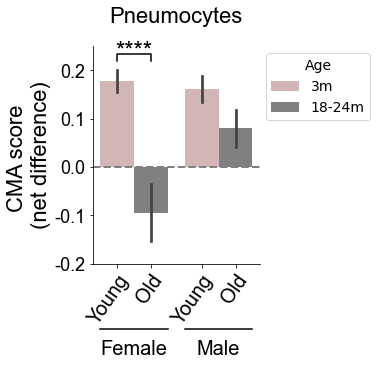

In [44]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='net_score', data=barcode[barcode.new_cell=='pneumocyte'], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.20, 0.25)
ax.set_yticks([-0.20, -0.10, 0.00, 0.10, 0.20])
ax.set_yticklabels([-0.20, -0.10, 0.00, 0.10, 0.20], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Pneumocytes', fontdict={'family':'Arial', 'size': 22}, y=1.08) 

# statistical annotation
x1, x2 = -0.2, 0.2   
y, h, col = 0.22 , 0.015, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, 0.215, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})


# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Lung/Pneu_ns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

#### Fibroblasts

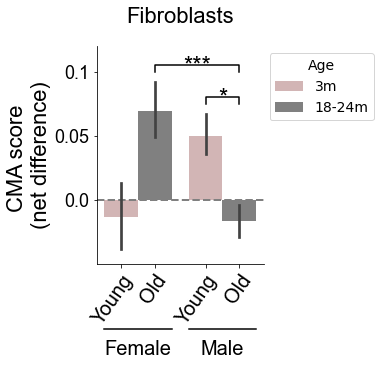

In [53]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='net_score', data=barcode[barcode.new_cell=='fibroblast'], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.05, 0.12)
ax.set_yticks([0.0, 0.05, 0.10])
ax.set_yticklabels([0.0, 0.05, 0.10], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Fibroblasts', fontdict={'family':'Arial', 'size': 22}, y=1.08)
 
# statistical annotation
x1, x2 = 0.8, 1.2   
y, h, col = 0.075 , 0.005, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-h, "*", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x1, x2 = 0.2, 1.2   
y, h, col = 0.1 , 0.005, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-h, "***", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Lung/Fib_ns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

#### Endothelial

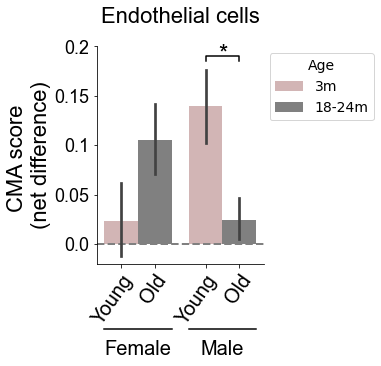

In [59]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='net_score', data=barcode[barcode.new_cell=='endothelial'], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.02, 0.20)
ax.set_yticks([0.0, 0.05, 0.10, 0.15, 0.20])
ax.set_yticklabels([0.0, 0.05, 0.10, 0.15, 0.20], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Endothelial cells', fontdict={'family':'Arial', 'size': 22}, y=1.08)
 
# statistical annotation
x1, x2 = 0.8, 1.2   
y, h, col = 0.185 , 0.005, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-h, "*", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Lung/End_ns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

### Raw data

In [60]:
# Extracting raw values for bar graphs graphic
def raw (tipos, edad, sex):
    long = []
    celula = []
    age = []
    mean=[]
    sem=[]
    sexo = []

    for i in tipos:
        for x in edad:
            for y in sex:
                n = len(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y].index)
                m = np.mean(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y]['net_score'])
                s = stats.sem(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y]['net_score'])

                long.append(n)
                celula.append(i)                
                age.append(x)
                sexo.append(y)
                mean.append(m)
                sem.append(s)

    df_raw = pd.DataFrame({"Cell_type": celula, "Age": age, "Sex":sexo, "n": long, "Mean":mean, "SEM": sem})
    with pd.ExcelWriter("../Khwaja_et_al_outputs/Lung/Raw_data.xlsx", mode="a", engine="openpyxl") as writer:
        df_raw.to_excel(writer, sheet_name="Nsbysex", index=False)
    return(df_raw)

In [61]:
raw(tipos = cells, edad=['3m', '18-24m'], sex=['female', 'male'])

C:\Users\Adrian\AppData\Local\Temp\ipykernel_8700\762371027.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n = len(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_8700\762371027.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = np.mean(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y]['net_score'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_8700\762371027.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  s = stats.sem(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y]['net_score'])


,Cell_type,Age,Sex,n,Mean,SEM
0,pneumocyte,3m,female,53,0.179016,0.023360
1,pneumocyte,3m,male,47,0.161400,0.027919
2,pneumocyte,18-24m,female,22,-0.095181,0.058160
3,pneumocyte,18-24m,male,49,0.081515,0.039915
4,fibroblast,3m,female,98,-0.013853,0.026140
5,fibroblast,3m,male,210,0.049634,0.016960
6,fibroblast,18-24m,female,126,0.069396,0.021331
7,fibroblast,18-24m,male,388,-0.016425,0.012407
8,endothelial,3m,female,33,0.023396,0.037381
9,endothelial,3m,male,57,0.139819,0.034975


## CMA net score/cell type & sex (fold over each cell type young)

In [11]:
# Calculation of net score (fold to 3m for each individual cell type)
for maj_cell in tqdm(np.unique(barcode['new_cell'])):
    
    µ = np.mean(barcode[barcode['new_cell'] == maj_cell][barcode['new_age'] == '3m']['score'])
    
    for cell_index in barcode[barcode['new_cell'] == maj_cell].index:
    
        barcode.loc[cell_index, 'celltype_ns'] = barcode.loc[cell_index, 'score'] - µ  

barcode.head()

  0%|                                                                                           | 0/28 [00:00<?, ?it/s]C:\Users\Adrian\AppData\Local\Temp\ipykernel_13440\2122786486.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  µ = np.mean(barcode[barcode['new_cell'] == maj_cell][barcode['new_age'] == '3m']['score'])
  4%|██▉                                                                                | 1/28 [00:01<00:29,  1.08s/it]C:\Users\Adrian\AppData\Local\Temp\ipykernel_13440\2122786486.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  µ = np.mean(barcode[barcode['new_cell'] == maj_cell][barcode['new_age'] == '3m']['score'])
100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:02<00:00, 10.57it/s]


,FACS.selection,age,cell,free_annotation,method,mouse.id,subtissue,n_genes,n_counts,louvain,...,organism,sex,tissue,ethnicity,development_stage,score,new_age,net_score,new_cell,celltype_ns
index,,,,,,,,,,,,,,,,,,,,,
A10_B000229_B009899_S10.mm10-plus-4-0,Multiple,18m,A10_B000229,Capillary,facs,18_53_M,Endomucin,1464,2954.479248,0,...,Mus musculus,male,lung,na,18 month-old stage,0.033605,18-24m,0.019078,bronchial smooth muscle cell,0.066587
A10_B000248_B009895_S10.mm10-plus-4-0,Multiple,18m,A10_B000248,Alveolar Fibroblast,facs,18_53_M,EPCAM,1445,2868.977783,12,...,Mus musculus,male,lung,na,18 month-old stage,0.028476,18-24m,0.013949,fibroblast,-0.015484
A10_B000265_B009901_S10.mm10-plus-4-0,Multiple,18m,A10_B000265,Capillary Aerocyte,facs,18_47_F,ENDOMUCIN,3839,4576.779297,1,...,Mus musculus,female,lung,na,18 month-old stage,0.448926,18-24m,0.434399,bronchial smooth muscle cell,0.481908
A10_B000266_B009900_S10.mm10-plus-4-0,Multiple,18m,A10_B000266,Capillary,facs,18_46_F,ENDOMUCIN,2940,5336.978516,1,...,Mus musculus,female,lung,na,18 month-old stage,0.216423,18-24m,0.201896,bronchial smooth muscle cell,0.249405
A10_B002258_B009940_S10.mm10-plus-4-0,Multiple,18m,A10_B002258,Capillary,facs,18_45_M,ENDOMUCIN,3122,4465.913086,2,...,Mus musculus,male,lung,na,18 month-old stage,0.349334,18-24m,0.334807,bronchial smooth muscle cell,0.382315


### Graphs

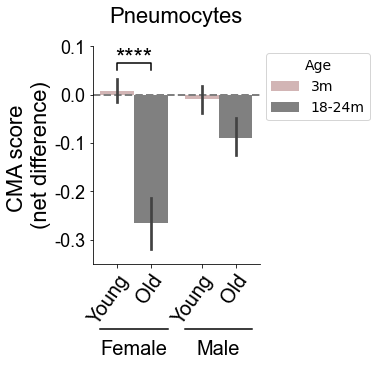

In [12]:
# Figure Pneumocytes
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[barcode.new_cell=='pneumocyte'], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.35, 0.10)
ax.set_yticks([-0.30, -0.20, -0.10, 0.00, 0.10])
ax.set_yticklabels([-0.30, -0.20, -0.10, 0.00, 0.10], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Pneumocytes', fontdict={'family':'Arial', 'size': 22}, y=1.08)

# statistical annotation
x1, x2 = -0.2, 0.2   
y, h, col = 0.05 , 0.015, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Lung/Pneu_cellns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

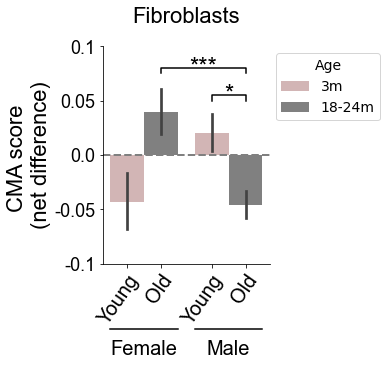

In [13]:
# Figure Fibroblasts
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[barcode.new_cell=='fibroblast'], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.10, 0.10)
ax.set_yticks([-0.10, -0.05, 0.00, 0.05, 0.10])
ax.set_yticklabels([-0.10, -0.05, 0.00, 0.05, 0.10], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Fibroblasts', fontdict={'family':'Arial', 'size': 22}, y=1.08)

# statistical annotation
x1, x2 = 0.8, 1.2   
y, h, col = 0.05 , 0.005, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-h, "*", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x1, x2 = 0.2, 1.2   
y, h, col = 0.075 , 0.005, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-h, "***", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Lung/Fib_cellns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

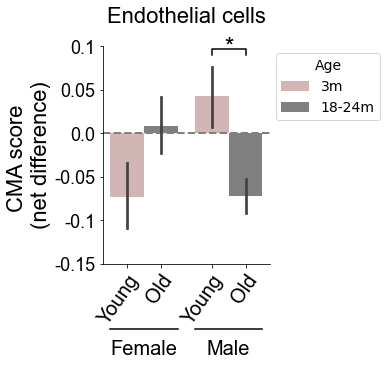

In [14]:
# Figure Endothelial
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[barcode.new_cell=='endothelial'], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.15, 0.10)
ax.set_yticks([-0.15, -0.10, -0.05, 0.00, 0.05, 0.10])
ax.set_yticklabels([-0.15, -0.10, -0.05, 0.00, 0.05, 0.10], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Endothelial cells', fontdict={'family':'Arial', 'size': 22}, y=1.08)

# statistical annotation
x1, x2 = 0.8, 1.2   
y, h, col = 0.09 , 0.007, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-0.005, "*", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Lung/End_cellns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

### Raw data

In [25]:
# Extracting raw values for bar graphs graphic
def raw (tipos, edad, sex):
    long = []
    celula = []
    age = []
    mean=[]
    sem=[]
    sexo = []

    for i in tipos:
        for x in edad:
            for y in sex:
                n = len(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y].index)
                m = np.mean(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y]['celltype_ns'])
                s = stats.sem(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y]['celltype_ns'])

                long.append(n)
                celula.append(i)                
                age.append(x)
                sexo.append(y)
                mean.append(m)
                sem.append(s)

    df_raw = pd.DataFrame({"Cell_type": celula, "Age": age, "Sex":sexo, "n": long, "Mean":mean, "SEM": sem})
    with pd.ExcelWriter("../Khwaja_et_al_outputs/Lung/Raw_data.xlsx", mode="a", engine="openpyxl") as writer:
        df_raw.to_excel(writer, sheet_name="CellNsbysex", index=False)
    return(df_raw)

In [26]:
raw(tipos = cells, edad=['3m', '18-24m'], sex=['female', 'male'])

C:\Users\Adrian\AppData\Local\Temp\ipykernel_13440\1302874723.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n = len(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_13440\1302874723.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = np.mean(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y]['celltype_ns'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_13440\1302874723.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  s = stats.sem(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y]['celltype_ns'])


,Cell_type,Age,Sex,n,Mean,SEM
0,pneumocyte,3m,female,53,0.008280,0.023360
1,pneumocyte,3m,male,47,-0.009337,0.027919
2,pneumocyte,18-24m,female,22,-0.265918,0.058160
3,pneumocyte,18-24m,male,49,-0.089222,0.039915
4,fibroblast,3m,female,98,-0.043286,0.026140
5,fibroblast,3m,male,210,0.020200,0.016960
6,fibroblast,18-24m,female,126,0.039962,0.021331
7,fibroblast,18-24m,male,388,-0.045858,0.012407
8,endothelial,3m,female,33,-0.073735,0.037381
9,endothelial,3m,male,57,0.042688,0.034975


## CMA network heatmaps by cell type & sex

In [62]:
# Load matrix reordered
model_matrix = pd.read_excel('../Exp. 2_Tabula muris/activation_model.xlsx', 'reordered')

# Removing EEF1A1 and RAC1 because they don't appear in the adata
model_matrix = model_matrix.drop([6, 8], axis=0).reset_index()

# Mapping data from adata to new order of CMA network
cma_network = adata[:, model_matrix["Ensembl_ms"]]

# GFAP does not appear in some cell types, creating a list without it
nogfap = ['LAMP2', 'HSPA8', 'HSP90AA1', 'HSP90AB1', 'DNAJB1', 'PHLPP1', 'NFATC1', 'NCOR1', 'NFE2L2', 'RAB11A', 
          'RICTOR', 'AKT1', 'AKT2', 'CTSA', 'RARA']

In [71]:
def sex_heatmaps(cellpop):
    
    # Prepare empty matrix
    matrix = np.zeros((16, 4))
    
    #Find cell indices for each condition
    female_3m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "3m"].index)
    female_18_24m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "18-24m"].index)
    male_3m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "3m"].index)
    male_18_24m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "18-24m"].index)
    
    #Calculate mean per gene for every condition
    for rank in tqdm(np.arange(matrix.shape[0])):    
        matrix[rank, 0] = np.mean(cma_network[female_3m, :].X.todense()[:, rank])
        matrix[rank, 1] = np.mean(cma_network[female_18_24m, :].X.todense()[:, rank])
        matrix[rank, 2] = np.mean(cma_network[male_3m, :].X.todense()[:, rank])
        matrix[rank, 3] = np.mean(cma_network[male_18_24m, :].X.todense()[:, rank])
            
    #Perform z-scoring on each row
    matrix_zs = matrix.copy()

    for i in np.arange(matrix_zs.shape[0]):
    
        µ = np.mean(matrix_zs[i, :])
        sd = np.std(matrix_zs[i, :])
    
        matrix_zs[i, :] = (matrix_zs[i, :] - µ) / sd     
    
    # Saving raw data
    df_m = pd.DataFrame(matrix_zs, columns=['female_young', 'female_old', 'male_young', 'male_old'], 
                        index=model_matrix['Gene name'])
    with pd.ExcelWriter("../Khwaja_et_al_outputs/Lung/Raw_data.xlsx", mode="a", engine="openpyxl") as writer:
        df_m.to_excel(writer, sheet_name=cellpop+'_heat', index=True)
        
    #Plot heatmap including all conditions
    if cellpop == 'pneumocyte' or cellpop == 'endothelial':
        matrix_zs = np.delete(matrix_zs,(5), axis=0)
        fig, ax = plt.subplots(figsize=(6,6))
        hfont = {'fontname':'Arial'}
        plt.imshow(matrix_zs, cmap='viridis', vmin=-1.5, vmax=1.5) 
        plt.colorbar(shrink=.5).set_label(label="Gene Z score", size=16, **hfont)

        plt.yticks(np.arange(15), nogfap, fontsize=16, **hfont)

        plt.ylim(14.5, -0.5)

        plt.xticks(np.arange(4), ['3m', '18-24m', '3m', '18-24m'], rotation=55, ha='right', rotation_mode='anchor',fontsize=16, **hfont)
        
        if cellpop == 'endothelial':
            plt.title(cellpop.title()+' cells', fontdict={'family':'Arial', 'size': 22}, y=1.05)
        else:
            plt.title(cellpop.title(), fontdict={'family':'Arial', 'size': 22}, y=1.05)
            
        plt.axvline(x=1.5, linestyle='dashed', linewidth=2, color='k', zorder=1)
        
        # Annotations
        trans = ax.get_yaxis_transform()
        trans2 = ax.get_xaxis_transform()
        ax.annotate('Effectors', xy=(-1.5, 0.25), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='k', size=16, **hfont)
        ax.plot([-1.25,-1.25],[-0.25, 4.25], color="k", transform=trans, clip_on=False)
        ax.annotate('Pos. regulators', xy=(-1.5, 4.5), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='green', size=16, **hfont)
        ax.plot([-1.25,-1.25],[4.75, 9.25], color="k", transform=trans, clip_on=False)
        ax.annotate('Neg. regulators', xy=(-1.5, 9.75), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='red', size=16, **hfont)
        ax.plot([-1.25,-1.25],[10, 14.25], color="k", transform=trans, clip_on=False)
        ax.annotate('Female', xy=(0.4, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([-.5,1.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)

        ax.annotate('Male', xy=(2.6, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([1.5, 3.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)
        
    else:
        fig, ax = plt.subplots(figsize=(6,6))
        hfont = {'fontname':'Arial'}

        plt.imshow(matrix_zs, cmap='viridis', vmin=-1.5, vmax=1.5)
        plt.colorbar(shrink=.5).set_label(label="Gene Z score", size=16, **hfont)

        plt.yticks(np.arange(16), model_matrix['Gene name'], fontsize=16, **hfont)

        plt.ylim(15.5, -0.5)

        plt.xticks(np.arange(4), ['3m', '18-24m', '3m', '18-24m'], rotation=55, ha='right', rotation_mode='anchor',fontsize=16, **hfont)
        plt.title(cellpop.title(), fontdict={'family':'Arial', 'size': 22}, y=1.05)

        plt.axvline(x=1.5, linestyle='dashed', linewidth=2, color='k', zorder=1)

        # Annotations
        trans = ax.get_yaxis_transform()
        trans2 = ax.get_xaxis_transform()
        ax.annotate('Effectors', xy=(-1.5, 0), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='k', size=16, **hfont)
        ax.plot([-1.25,-1.25],[-0.25, 4.25], color="k", transform=trans, clip_on=False)

        ax.annotate('Pos. regulators', xy=(-1.5, 4.75), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='green', size=16, **hfont)
        ax.plot([-1.25,-1.25],[4.75, 10.25], color="k", transform=trans, clip_on=False)

        ax.annotate('Neg. regulators', xy=(-1.5, 10.5), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='red', size=16, **hfont)
        ax.plot([-1.25,-1.25],[11, 15.25], color="k", transform=trans, clip_on=False)

        ax.annotate('Female', xy=(0.4, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([-.5,1.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)

        ax.annotate('Male', xy=(2.6, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([1.5, 3.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)

    
    plt.savefig('../Khwaja_et_al_outputs/Lung/{}_heat.png'.format(cellpop),bbox_inches='tight', dpi=300)
    
    plt.show()

C:\Users\Adrian\AppData\Local\Temp\ipykernel_8700\336808802.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_3m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "3m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_8700\336808802.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_18_24m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "18-24m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_8700\336808802.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_3m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "3m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_8700\336808802.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_18_24m = list(barcode[barcode['new_cell'] == cellpop][

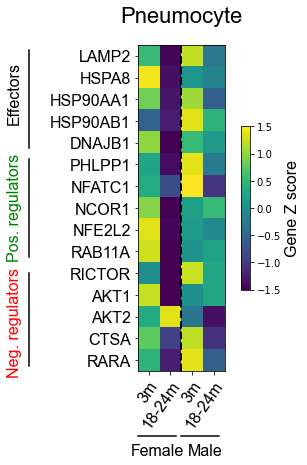

C:\Users\Adrian\AppData\Local\Temp\ipykernel_8700\336808802.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_3m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "3m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_8700\336808802.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_18_24m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "18-24m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_8700\336808802.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_3m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "3m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_8700\336808802.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_18_24m = list(barcode[barcode['new_cell'] == cellpop][

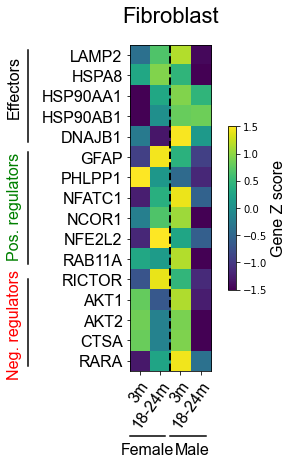

C:\Users\Adrian\AppData\Local\Temp\ipykernel_8700\336808802.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_3m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "3m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_8700\336808802.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_18_24m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "18-24m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_8700\336808802.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_3m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "3m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_8700\336808802.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_18_24m = list(barcode[barcode['new_cell'] == cellpop][

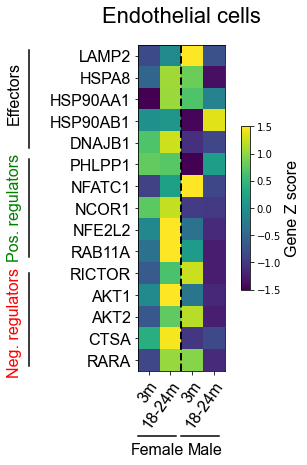

In [72]:
for i in cells:
    sex_heatmaps(cellpop=i)

## Ridge plots for L2 and L1

In [3]:
# Codes for L2 and L1
lys = ['ENSMUSG00000016534', 'ENSMUSG00000031447']

In [4]:
# Selecting only L2 and L1 from adata
adata_lys = adata[:, lys]
barcode_lys = adata.obs.copy()

# Calculating the Z score for L2 & L1
lys_zs = adata_lys.copy().X.todense()

for i in tqdm(np.arange(lys_zs.shape[1])):
    
    µ = np.mean(lys_zs[:, i])
    sd = np.std(lys_zs[:, i])
    
    lys_zs[:, i] = (lys_zs[:, i] - µ)/sd
    
# Converting lys_zs.X to a pandas df
df_lys = pd.DataFrame(lys_zs.tolist())
df_lys.rename(columns={0:"L2", 1:'L1'}, inplace=True)

# Generating barcode df and appending L2 column
barcode_lys = barcode_lys.reset_index()
barcode_lys = pd.concat([barcode_lys, df_lys], axis=1)
barcode_lys = barcode_lys [['index', 'cell', 'cell_type', 'sex', 'age', 'L2', 'L1']]

barcode_lys.head()

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 999.95it/s]


,index,cell,cell_type,sex,age,L2,L1
0,A10_B000229_B009899_S10.mm10-plus-4-0,A10_B000229,bronchial smooth muscle cell,male,18m,1.232089,0.767138
1,A10_B000248_B009895_S10.mm10-plus-4-0,A10_B000248,fibroblast of lung,male,18m,0.720465,0.229648
2,A10_B000265_B009901_S10.mm10-plus-4-0,A10_B000265,bronchial smooth muscle cell,female,18m,1.175798,0.626533
3,A10_B000266_B009900_S10.mm10-plus-4-0,A10_B000266,bronchial smooth muscle cell,female,18m,-0.982487,0.505914
4,A10_B002258_B009940_S10.mm10-plus-4-0,A10_B002258,bronchial smooth muscle cell,male,18m,-0.982487,0.680138


In [5]:
cells2 = ['type I pneumocyte', 'type II pneumocyte', 'fibroblast of lung', 'adventitial cell', 
         'pulmonary interstitial fibroblast', 'vein endothelial cell', 'endothelial cell of lymphatic vessel'] 

In [6]:
# Generating new ages
for j in barcode_lys.index:    
    if barcode_lys.loc[j, 'age'] == '3m':        
        barcode_lys.loc[j, 'new_age'] = '3m'

    elif barcode_lys.loc[j, 'age'] == '18m':                
        barcode_lys.loc[j, 'new_age'] = '18-24m'

    elif barcode_lys.loc[j, 'age'] == '24m': 
        barcode_lys.loc[j, 'new_age'] = '18-24m'

# Generating new cell types combining some of them
for j in barcode_lys.index:    
    if barcode_lys.loc[j, 'cell_type'] == cells2[0]:        
        barcode_lys.loc[j, 'new_cell'] = 'pneumocyte'

    elif barcode_lys.loc[j, 'cell_type'] == cells2[1]:                
        barcode_lys.loc[j, 'new_cell'] = 'pneumocyte'

    elif barcode_lys.loc[j, 'cell_type'] == cells2[2]:                
        barcode_lys.loc[j, 'new_cell'] = 'fibroblast'
    
    elif barcode_lys.loc[j, 'cell_type'] == cells2[3]:                
        barcode_lys.loc[j, 'new_cell'] = 'fibroblast'
    
    elif barcode_lys.loc[j, 'cell_type'] == cells2[4]:                
        barcode_lys.loc[j, 'new_cell'] = 'fibroblast'
    
    elif barcode_lys.loc[j, 'cell_type'] == cells2[5]:                
        barcode_lys.loc[j, 'new_cell'] = 'endothelial'
    
    elif barcode_lys.loc[j, 'cell_type'] == cells2[6]:                
        barcode_lys.loc[j, 'new_cell'] = 'endothelial'
    
    else:
        barcode_lys.loc[j, 'new_cell'] = barcode_lys.loc[j, 'cell_type']
        
barcode_lys.head()

,index,cell,cell_type,sex,age,L2,L1,new_age,new_cell
0,A10_B000229_B009899_S10.mm10-plus-4-0,A10_B000229,bronchial smooth muscle cell,male,18m,1.232089,0.767138,18-24m,bronchial smooth muscle cell
1,A10_B000248_B009895_S10.mm10-plus-4-0,A10_B000248,fibroblast of lung,male,18m,0.720465,0.229648,18-24m,fibroblast
2,A10_B000265_B009901_S10.mm10-plus-4-0,A10_B000265,bronchial smooth muscle cell,female,18m,1.175798,0.626533,18-24m,bronchial smooth muscle cell
3,A10_B000266_B009900_S10.mm10-plus-4-0,A10_B000266,bronchial smooth muscle cell,female,18m,-0.982487,0.505914,18-24m,bronchial smooth muscle cell
4,A10_B002258_B009940_S10.mm10-plus-4-0,A10_B002258,bronchial smooth muscle cell,male,18m,-0.982487,0.680138,18-24m,bronchial smooth muscle cell


In [9]:
# Reducing df only to cells of interest
barcode_lys = barcode_lys[(barcode_lys.new_cell==cells[0]) | (barcode_lys.new_cell==cells[1]) |
                         (barcode_lys.new_cell==cells[2])].reset_index(drop=True)

### Graphs

#### Lamp2 female

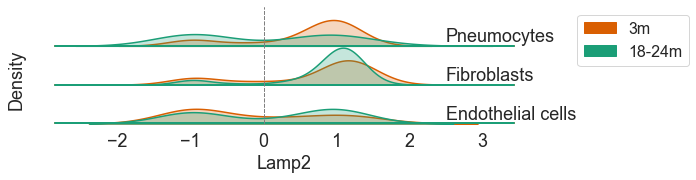

In [11]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), "axes.labelsize":18, "xtick.labelsize":18}, 
              font_scale=2)

g = sns.FacetGrid(barcode_lys[barcode_lys.sex == 'female'], row='new_cell', row_order = cells, hue='new_age', 
                  hue_order= ['3m', '18-24m'], aspect=7, height=1.1, palette=['#d95f02', '#1b9e77'])
g.map(sns.kdeplot, 'L2', bw_adjust=1, clip_on=False, fill=True, alpha=0.25, linewidth=1.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)
g.map(plt.axvline, x=0, lw=1, clip_on=False, color='gray', linestyle='dashed')

g.fig.subplots_adjust(hspace=0)

plt.text(x=2.5, y=2.5, s="Pneumocytes", fontsize=18) 
plt.text(x=2.5, y=1.3, s="Fibroblasts", fontsize=18)
plt.text(x=2.5, y=0.12, s="Endothelial cells", fontsize=18)


# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel='')
g.set(xlabel='Lamp2')
g.fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=18)
g.despine(bottom=True, left=True)

# Legend
legend_elements = [Patch(facecolor='#d95f02', edgecolor='#d95f02', label='3m'),
                   Patch(facecolor='#1b9e77', edgecolor='#1b9e77', label='18-24m')]

plt.legend(handles=legend_elements, bbox_to_anchor = (1.4, 3), facecolor='white', fontsize=16)

plt.savefig('../Khwaja_et_al_outputs/Lung/LungL2_ridge_fem.png',bbox_inches='tight', dpi=300)
plt.show()

#### Lamp2 male

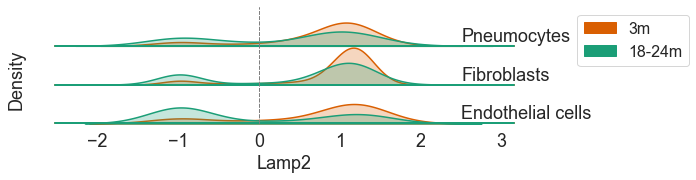

In [12]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), "axes.labelsize":18, "xtick.labelsize":18}, 
              font_scale=2)

g = sns.FacetGrid(barcode_lys[barcode_lys.sex == 'male'], row='new_cell', row_order = cells, hue='new_age', 
                  hue_order= ['3m', '18-24m'], aspect=7, height=1.1, palette=['#d95f02', '#1b9e77'])
g.map(sns.kdeplot, 'L2', bw_adjust=1, clip_on=False, fill=True, alpha=0.25, linewidth=1.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)
g.map(plt.axvline, x=0, lw=1, clip_on=False, color='gray', linestyle='dashed')

g.fig.subplots_adjust(hspace=0)

plt.text(x=2.5, y=2.9, s="Pneumocytes", fontsize=18) 
plt.text(x=2.5, y=1.52, s="Fibroblasts", fontsize=18)
plt.text(x=2.5, y=0.15, s="Endothelial cells", fontsize=18)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel='')
g.set(xlabel='Lamp2')
g.fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=18)
g.despine(bottom=True, left=True)

# Legend
legend_elements = [Patch(facecolor='#d95f02', edgecolor='#d95f02', label='3m'),
                   Patch(facecolor='#1b9e77', edgecolor='#1b9e77', label='18-24m')]

plt.legend(handles=legend_elements, bbox_to_anchor = (1.4, 3), facecolor='white', fontsize=16)

plt.savefig('../Khwaja_et_al_outputs/Lung/LungL2_ridge_male.png',bbox_inches='tight', dpi=300)
plt.show()

#### Lamp1 female

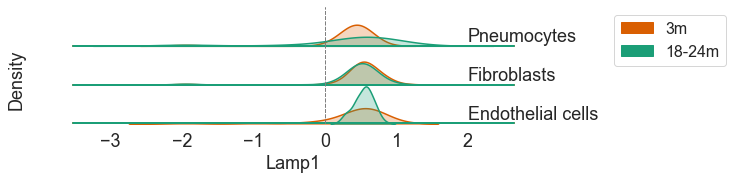

In [13]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), "axes.labelsize":18, "xtick.labelsize":18}, 
              font_scale=2)

g = sns.FacetGrid(barcode_lys[barcode_lys.sex == 'female'], row='new_cell', row_order = cells, hue='new_age', 
                  hue_order= ['3m', '18-24m'], aspect=7, height=1.1, palette=['#d95f02', '#1b9e77'])
g.map(sns.kdeplot, 'L1', bw_adjust=1, clip_on=False, fill=True, alpha=0.25, linewidth=1.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)
g.map(plt.axvline, x=0, lw=1, clip_on=False, color='gray', linestyle='dashed')

g.fig.subplots_adjust(hspace=0)

plt.text(x=2, y=6.3, s="Pneumocytes", fontsize=18) 
plt.text(x=2, y=3.3, s="Fibroblasts", fontsize=18)
plt.text(x=2, y=0.3, s="Endothelial cells", fontsize=18)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel='')
g.set(xlabel='Lamp1')
g.fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=18)
g.despine(bottom=True, left=True)

# Legend
legend_elements = [Patch(facecolor='#d95f02', edgecolor='#d95f02', label='3m'),
                   Patch(facecolor='#1b9e77', edgecolor='#1b9e77', label='18-24m')]

plt.legend(handles=legend_elements, bbox_to_anchor = (1.5, 3), facecolor='white', fontsize=16)

plt.savefig('../Khwaja_et_al_outputs/Lung/LungL1_ridge_fem.png',bbox_inches='tight', dpi=300)
plt.show()

#### Lamp1 male

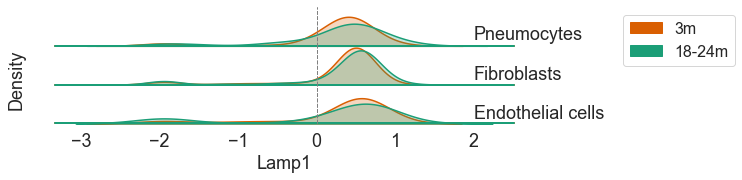

In [14]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), "axes.labelsize":18, "xtick.labelsize":18}, 
              font_scale=2)

g = sns.FacetGrid(barcode_lys[barcode_lys.sex == 'male'], row='new_cell', row_order = cells, hue='new_age', 
                  hue_order= ['3m', '18-24m'], aspect=7, height=1.1, palette=['#d95f02', '#1b9e77'])
g.map(sns.kdeplot, 'L1', bw_adjust=1, clip_on=False, fill=True, alpha=0.25, linewidth=1.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)
g.map(plt.axvline, x=0, lw=1, clip_on=False, color='gray', linestyle='dashed')

g.fig.subplots_adjust(hspace=0)

plt.text(x=2, y=3.1, s="Pneumocytes", fontsize=18) 
plt.text(x=2, y=1.6, s="Fibroblasts", fontsize=18)
plt.text(x=2, y=0.15, s="Endothelial cells", fontsize=18)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel='')
g.set(xlabel='Lamp1')
g.fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=18)
g.despine(bottom=True, left=True)

# Legend
legend_elements = [Patch(facecolor='#d95f02', edgecolor='#d95f02', label='3m'),
                   Patch(facecolor='#1b9e77', edgecolor='#1b9e77', label='18-24m')]

plt.legend(handles=legend_elements, bbox_to_anchor = (1.5, 3), facecolor='white', fontsize=16)

plt.savefig('../Khwaja_et_al_outputs/Lung/LungL1_ridge_male.png',bbox_inches='tight', dpi=300)
plt.show()

## L2 Bar graphs

### Stats

In [27]:
# 2-way Anova for all cells
for i in cells:
    intdf = barcode_lys[barcode_lys['new_cell']==i].reset_index(drop=True)    
    
    # 2-way Anova
    model = ols('L2 ~ C(new_age) + C(sex) + C(new_age):C(sex)',data=intdf).fit()
    result = sm.stats.anova_lm(model, type=2)
    print(i.title()+' 2-way Anova\n')
    print(result)
    print('\n')
    
    # Post hocs multi comparissons Bonferroni
    interaction_groups = intdf.new_age.astype(str) + " & " + intdf.sex.astype(str)
    comp = mc.MultiComparison(intdf['L2'], interaction_groups)
    tbl, a1, a2 = comp.allpairtest(stats.ttest_ind, method= "bonf")
    print(i.title()+' Post-Hoc Bonferroni\n')
    print(tbl)
    print('\n')

Pneumocyte 2-way Anova

                      df      sum_sq   mean_sq          F    PR(>F)
C(new_age)           1.0    7.216943  7.216943  10.600334  0.001369
C(sex)               1.0    2.239195  2.239195   3.288957  0.071543
C(new_age):C(sex)    1.0    0.138982  0.138982   0.204138  0.651988
Residual           167.0  113.697309  0.680822        NaN       NaN


Pneumocyte Post-Hoc Bonferroni

Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.01, alphacBonf=0.008
     group1         group2      stat   pval  pval_corr reject
-------------------------------------------------------------
18-24m & female 18-24m & male -1.2787 0.2053       1.0  False
18-24m & female   3m & female -2.6087  0.011    0.0661  False
18-24m & female     3m & male -3.5322 0.0008    0.0045   True
  18-24m & male   3m & female -1.3876 0.1683       1.0  False
  18-24m & male     3m & male -2.4886 0.0146    0.0875  False
    3m & female     3m & male -1.3115 0.1928       1.0  False
-------------

### Graphs

In [28]:
sns.reset_defaults()

#### Pneumocytes

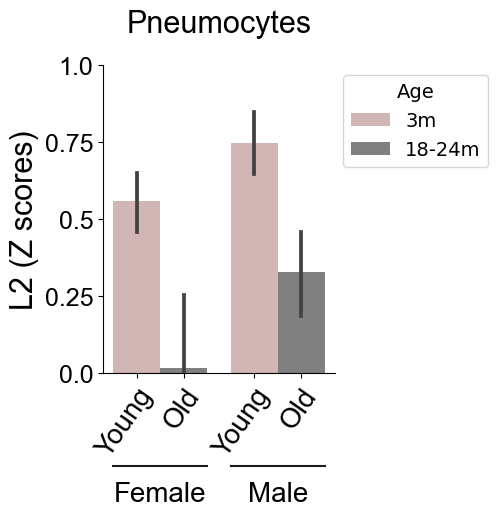

In [38]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='L2', data=barcode_lys[barcode_lys.new_cell=='pneumocyte'], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.xlabel('')
plt.ylabel('L2 (Z scores)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(0, 1)
ax.set_yticks([0.0, 0.25, 0.50, 0.75, 1.0])
ax.set_yticklabels([0.0, 0.25, 0.50, 0.75, 1.0], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14, 
          facecolor='white')
plt.title(label='Pneumocytes', fontdict={'family':'Arial', 'size': 22}, y=1.08) 

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Lung/Pneu_L2_sex.png',bbox_inches='tight', dpi=300)

plt.show()

#### Fibroblasts

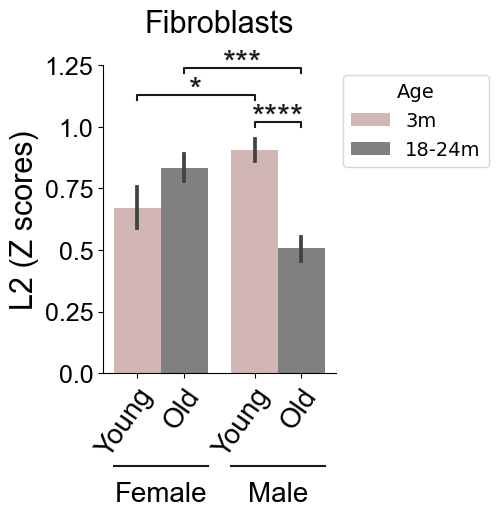

In [53]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='L2', data=barcode_lys[barcode_lys.new_cell=='fibroblast'], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.xlabel('')
plt.ylabel('L2 (Z scores)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(0, 1.25)
ax.set_yticks([0.0, 0.25, 0.50, 0.75, 1.0, 1.25])
ax.set_yticklabels([0.0, 0.25, 0.50, 0.75, 1.0, 1.25], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14, 
          facecolor='white')
plt.title(label='Fibroblasts', fontdict={'family':'Arial', 'size': 22}, y=1.08) 

# statistical annotation
x1, x2 = 0.8, 1.2   
y, h, col = 1 , 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, 0.97, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x1, x2 = -0.2, 0.8   
y, h, col = 1.11 , 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-0.03, "*", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x1, x2 = 0.2, 1.2   
y, h, col = 1.22, 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-0.03, "***", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})


# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Lung/Fib_L2_sex.png',bbox_inches='tight', dpi=300)

plt.show()

#### Endothelial cells

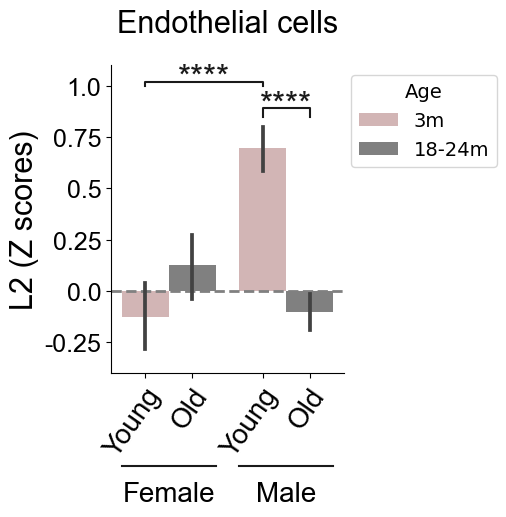

In [74]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='L2', data=barcode_lys[barcode_lys.new_cell=='endothelial'], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('L2 (Z scores)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.40, 1.10)
ax.set_yticks([-0.25, 0.0, 0.25, 0.50, 0.75, 1.0])
ax.set_yticklabels([-0.25, 0.0, 0.25, 0.50, 0.75, 1.0], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14, 
          facecolor='white')
plt.title(label='Endothelial cells', fontdict={'family':'Arial', 'size': 22}, y=1.08) 

# statistical annotation
x1, x2 = 0.8, 1.2   
y, h, col = 0.85 , 0.04, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-0.02, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x1, x2 = -0.2, 0.8   
y, h, col = 1 , 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-0.04, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Lung/End_L2_sex.png',bbox_inches='tight', dpi=300)

plt.show()

### Raw data

In [22]:
# Extracting raw values for bar graphs graphic
def raw (tipos, edad, sex):
    long = []
    celula = []
    age = []
    mean=[]
    sem=[]
    sexo = []

    for i in tipos:
        for x in edad:
            for y in sex:
                n = len(barcode_lys[barcode_lys['new_cell']== i][barcode_lys['new_age']== x][barcode_lys['sex']== y].index)
                m = np.mean(barcode_lys[barcode_lys['new_cell']== i][barcode_lys['new_age']== x][barcode_lys['sex']== y]['L2'])
                s = stats.sem(barcode_lys[barcode_lys['new_cell']== i][barcode_lys['new_age']== x][barcode_lys['sex']== y]['L2'])

                long.append(n)
                celula.append(i)                
                age.append(x)
                sexo.append(y)
                mean.append(m)
                sem.append(s)

    df_raw = pd.DataFrame({"Cell_type": celula, "Age": age, "Sex":sexo, "n": long, "Mean":mean, "SEM": sem})
    with pd.ExcelWriter("../Khwaja_et_al_outputs/Lung/Raw_data.xlsx", mode="a", if_sheet_exists='replace', 
                        engine="openpyxl") as writer:
        df_raw.to_excel(writer, sheet_name="L2bysex", index=False)
    return(df_raw)

In [21]:
raw(tipos = cells, edad=['3m', '18-24m'], sex=['female', 'male'])

C:\Users\Adrian\AppData\Local\Temp\ipykernel_8128\2710847262.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n = len(barcode_lys[barcode_lys['new_cell']== i][barcode_lys['new_age']== x][barcode_lys['sex']== y].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_8128\2710847262.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = np.mean(barcode_lys[barcode_lys['new_cell']== i][barcode_lys['new_age']== x][barcode_lys['sex']== y]['L2'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_8128\2710847262.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  s = stats.sem(barcode_lys[barcode_lys['new_cell']== i][barcode_lys['new_age']== x][barcode_lys['sex']== y]['L2'])


,Cell_type,Age,Sex,n,Mean,SEM
0,pneumocyte,3m,female,53,0.558021,0.101955
1,pneumocyte,3m,male,47,0.748380,0.102654
2,pneumocyte,18-24m,female,22,0.015433,0.210387
3,pneumocyte,18-24m,male,49,0.327172,0.133339
4,fibroblast,3m,female,98,0.668588,0.085419
5,fibroblast,3m,male,210,0.906167,0.043333
6,fibroblast,18-24m,female,126,0.833313,0.056345
7,fibroblast,18-24m,male,388,0.506334,0.046681
8,endothelial,3m,female,33,-0.126560,0.165078
9,endothelial,3m,male,57,0.699094,0.110971
